In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data

Load the data

In [51]:
df=pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')

Reverse the order of the data, some plottings will go better if the oldest dates are on top of the dataframe.

In [52]:
df=df.iloc[::-1]

Also, stripping out the year and turning the date into a string will simplify plotting.

In [53]:
df['Date']=df['date'].astype(str).str[5:]
df['DateTime']=pd.to_datetime(df['date'], format='%Y%m%d')

# Question 1:  How many states?

How many different "states" are there?

In [56]:
(np.unique(df['state']))

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [5]:
#print(np.unique(df['state']))
print('There are %d unique state entries, must be including territories.'%len(np.unique(df['state'])))

There are 56 unique state entries, must be including territories.


# Question 2: Which 5 states have highest positive testing rate?

First we will make a new dataframe that has just the states, positives, negatives, and the positive fraction.

In [57]:
possneg = df.pivot_table(index='state', aggfunc=np.max, values=['positive', 'negative']).reset_index()
possneg['PositiveRatio']=possneg['positive']/(possneg['positive']+possneg['negative'])
possneg.head()

,state,negative,positive,PositiveRatio
0,AK,763652.0,18174.0,0.023246
1,AL,1209841.0,199158.0,0.141347
2,AR,1285613.0,117360.0,0.083651
3,AS,1768.0,0.0,0.000000
4,AZ,1573861.0,252768.0,0.138379


Now find the 5 highest ratios.

In [59]:
possneg.sort_values(by='PositiveRatio', ascending=False)[0:5][['state', 'PositiveRatio']]

,state,PositiveRatio
45,SD,0.190056
42,PR,0.184918
15,ID,0.168756
31,ND,0.164495
14,IA,0.142658


# Question 3:  Plot daily death toll for whole country

Let's plot daily death toll for the whole country.

Text(0.5, 1.0, 'US Daily Death Toll')

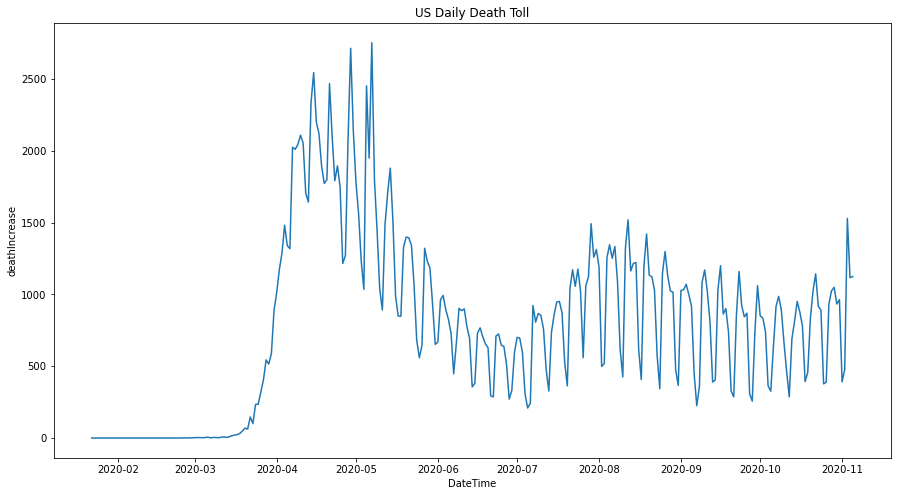

In [60]:
plt.figure(figsize=[15,8])
combined_df = df.pivot_table(index='DateTime', values='deathIncrease', aggfunc=np.sum).reset_index()
sns.lineplot(data=combined_df, x='DateTime', y='deathIncrease')
plt.title('US Daily Death Toll')

Let's smooth that out a bit using something from scipy

In [37]:
from scipy.interpolate import interp1d

Text(0.5, 1.0, 'US Daily Death Toll')

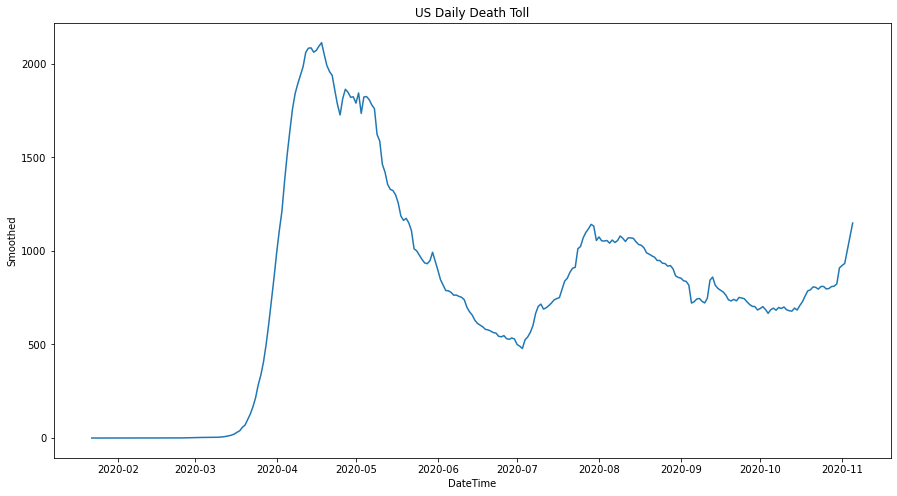

In [61]:
import scipy.signal
plt.figure(figsize=[15,8])
combined_df = df.pivot_table(index='DateTime', values='deathIncrease', aggfunc=np.sum).reset_index()
combined_df['Smoothed'] = scipy.signal.savgol_filter(combined_df['deathIncrease'], window_length=7, polyorder=1)
sns.lineplot(data=combined_df, x='DateTime', y='Smoothed')
plt.title('US Daily Death Toll')

# Question 4:  Plot daily death toll for just Kansas and Missouri

Now let's focus on Missouri and Kansas, first we will graph their combined totals.

Text(0.5, 1.0, 'Missouri + Kansas Daily Death Toll')

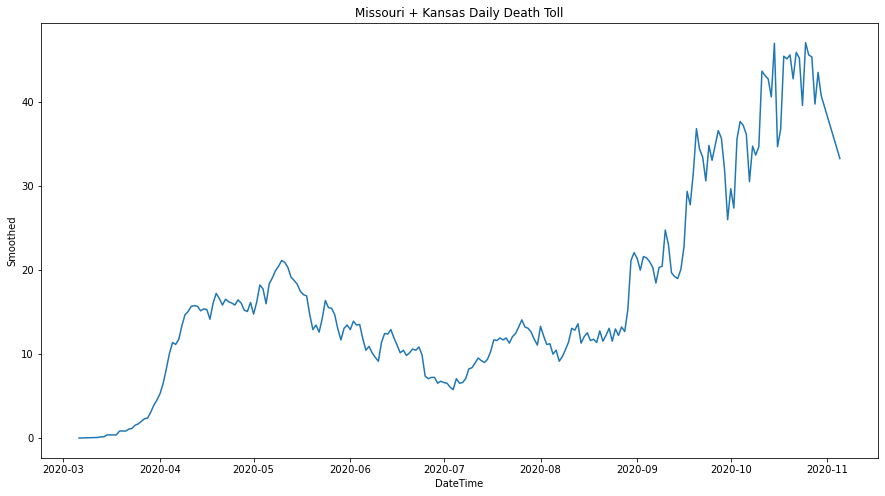

In [62]:
plt.figure(figsize=[15,8])
combined_df = df[df['state'].isin(['MO', 'KS'])].pivot_table(values='deathIncrease', 
                                                            aggfunc=np.sum, index='DateTime').reset_index()
combined_df['Smoothed'] = scipy.signal.savgol_filter(combined_df['deathIncrease'], window_length=13, polyorder=1)
sns.lineplot(data=combined_df, x='DateTime', y='Smoothed')
plt.title('Missouri + Kansas Daily Death Toll')

Now let's separate them out.

# Question 5:  Plot the daily testing rate for Kansas and Missouri

What is the daily testing rate looking like for Kansas and Missouri?

Text(0.5, 1.0, 'Missouri + Kansas Daily Testings')

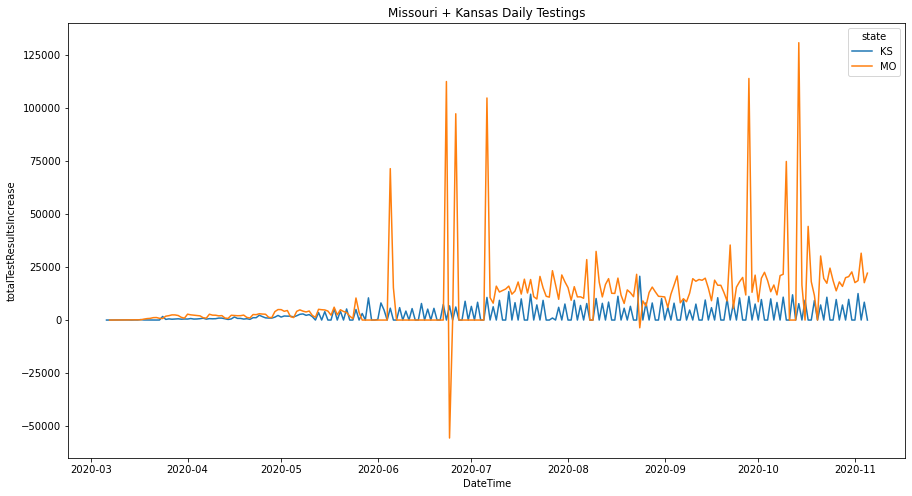

In [63]:
plt.figure(figsize=[15,8])
sns.lineplot(data=df[df['state'].isin(['MO', 'KS'])], x='DateTime', y='totalTestResultsIncrease', hue='state')
plt.title('Missouri + Kansas Daily Testings')

Again, we will smooth it out.

Text(0.5, 1.0, 'Missouri and Kansas Daily Death Toll')

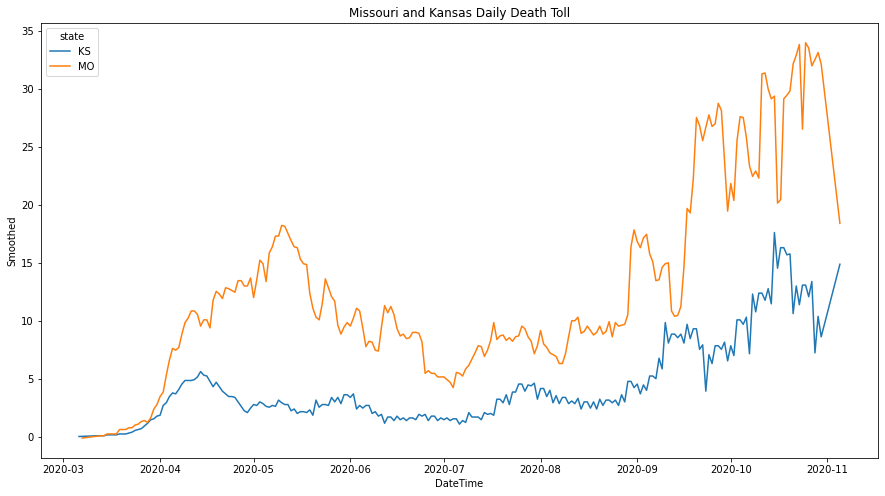

In [64]:
plt.figure(figsize=[15,8])
df.loc[df['state']=='MO','Smoothed'] = scipy.signal.savgol_filter(df.loc[df['state']=='MO']['deathIncrease'], window_length=13, polyorder=1)
df.loc[df['state']=='KS','Smoothed'] = scipy.signal.savgol_filter(df.loc[df['state']=='KS']['deathIncrease'], window_length=13, polyorder=1)
sns.lineplot(data=df[df['state'].isin(['MO', 'KS'])], x='DateTime', y='Smoothed', hue='state')
plt.title('Missouri and Kansas Daily Death Toll')

# Question 6:  What is the peak death day for the whole country?

In [69]:
agged_df = df.pivot_table(index='DateTime', values='positiveIncrease', aggfunc=np.sum).reset_index()
agged_df.iloc[np.argmax(agged_df['positiveIncrease'])]

DateTime            2020-11-05 00:00:00
positiveIncrease                 116255
Name: 288, dtype: object

So far it is May 7, on which 2752 died.

# Challenge 1:  Make a table of peak testing day for each state

This way uses lambda, groupby, and apply, 3 functions we have not used in the class.

In [16]:
df.groupby(['state']).apply(lambda x: x.iloc[np.argmax(x['totalTestResultsIncrease'])]).sort_values(by='DateTime')[['totalTestResultsIncrease','DateTime']]



,totalTestResultsIncrease,DateTime
state,,
ID,8188,2020-04-29
NJ,113486,2020-05-11
TN,54879,2020-06-12
AS,522,2020-06-25
PR,79467,2020-06-29
MP,2547,2020-07-08
AL,23846,2020-07-10
NV,14654,2020-07-11
FL,129145,2020-07-12


This way uses only things we have covered in class.

In [73]:
fff = df.sort_values(by='totalTestResultsIncrease', ascending=False)[['state', 'totalTestResultsIncrease', 'DateTime']]
asd, arrs = np.unique(fff['state'], return_index=True)
fff.iloc[arrs]

,state,totalTestResultsIncrease,DateTime
0,AK,154068,2020-11-05
6609,AL,23846,2020-07-10
2130,AR,57071,2020-09-28
7451,AS,522,2020-06-25
2748,AZ,23844,2020-09-17
565,CA,194944,2020-10-26
230,CO,41137,2020-11-01
1351,CT,100405,2020-10-12
232,DC,11116,2020-11-01
1409,DE,8353,2020-10-11


In [17]:
fff = df.sort_values(by='totalTestResultsIncrease', ascending=False)[['state', 'totalTestResultsIncrease', 'DateTime']]
asd, arrs = np.unique(fff['state'], return_index=True)
fff.iloc[arrs]

,state,totalTestResultsIncrease,DateTime
0,AK,154068,2020-11-05
6609,AL,23846,2020-07-10
2130,AR,57071,2020-09-28
7451,AS,522,2020-06-25
2748,AZ,23844,2020-09-17
565,CA,194944,2020-10-26
230,CO,41137,2020-11-01
1351,CT,100405,2020-10-12
232,DC,11116,2020-11-01
1409,DE,8353,2020-10-11


# Challenge 2:  Plot the per capita testing fraction in descending order

First let's make a new dataframe that simply aggregates the total tests per state.

In [18]:
tests_agged=df.groupby(['state']).agg({'totalTestResultsIncrease':np.sum}).reset_index()

Now let's read in the population data, and keep only the parts we want.

In [19]:
pop=pd.read_csv('http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv', usecols=['NAME', 'CENSUS2010POP'])

Now the problem is that our tests_agged has state abbreviations and our pop dataframe has full state names.  We need to convert one to the other before we can merge.

First let's load a file that has both.

In [20]:
abb=pd.read_csv('http://www.fonz.net/blog/wp-content/uploads/2008/04/states.csv')

Then we will make a dictionary that takes abbreviations and turns them into the full state names.

In [21]:
mapper={a:b for a,b in zip(abb['Abbreviation'], abb['State'])}

Now that we have a dictionary, we can create a new column in tests_agged and use .map to generate it.

In [22]:
tests_agged['StateNames']=tests_agged['state'].map(mapper)

Now we can merge the tests_agged and pop dataframes because they both have a column with the full state name in them.

In [23]:
tests_agged=tests_agged.merge(pop, left_on='StateNames', right_on='NAME')

Calculate the per 1000 tests, add to a column

In [24]:
tests_agged['PerThousand']=tests_agged['totalTestResultsIncrease']/tests_agged['CENSUS2010POP']*1000

Sort, show the top 5.

In [25]:
tests_agged.sort_values(by='PerThousand', ascending=False)[0:5].loc[:,['NAME', 'PerThousand']]

,NAME,PerThousand
28,North Dakota,1298.478570
39,Rhode Island,1140.783437
0,Alaska,1100.793967
19,Massachusetts,986.816755
7,District of Columbia,898.247200


<AxesSubplot:xlabel='PerThousand', ylabel='NAME'>

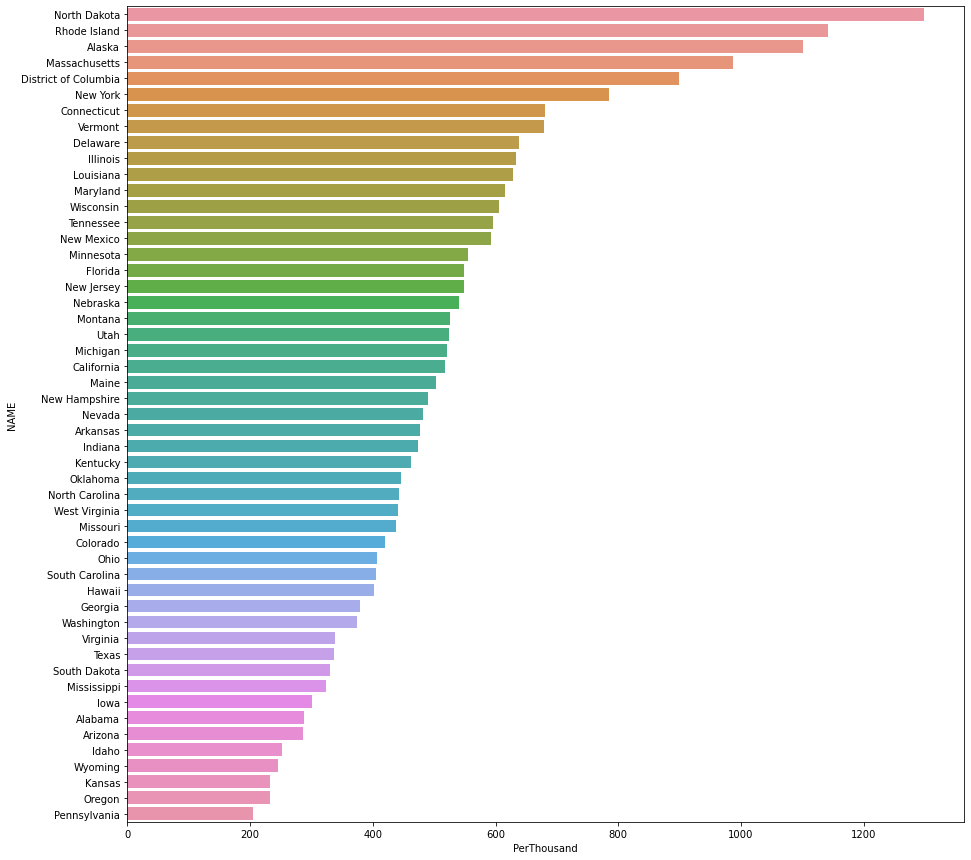

In [26]:
plt.figure(figsize=[15,15])
sns.barplot(data=tests_agged.sort_values(by='PerThousand', ascending=False), x='PerThousand', y='NAME')